# SDG water quality hack

Methodologies for remote sensing based reporting on water quality are defined under the Water Quality SDG Indicator 6.6.1, sub-indicator 5.

The methods specified are very simple, and have been implemented more as demonstration of concept rather than the best science possible. 

The purpose of this notebook was to explore the ease at which SDG methodologies are replicated. The use of other Earth Observation water quality metrics are explored.
Author: Erin Telfer, 6/11/2018. This notebook was exploratory in nature, no assurances are provided in use of this code.


In [10]:
import datacube
from datacube.utils import geometry
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
dc = datacube.Datacube()

import numpy as np
import fiona
import rasterio.features
import matplotlib.pyplot as plt
from IPython.display import Image
import math

import sys
import os
sys.path.append('../dea-notebooks/10_Scripts')
import DEAPlotting

## Use shapefile to return relevant data

In [3]:
# Set this to the location of water body shapefile
shape_file = os.path.expanduser('2015_Bathymetry_Lake_Burley_Griffin_Extent.shp')

#open shapefile and save spatial variables
with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

## Load Sentinel 2 data for the polygon of interest

In [4]:
#create query
query = {'geopolygon': geom,
#         'lat': (-35.27, -35.33),
#         'lon': (149.07, 149.15),
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        'time': ('2016-01-01', '2017-01-01')
        }
#load data
ds = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)

# Use this code to mask out cloud and cloud shadow. Note Sentinel 2 cloud masking is poor
# clear_pixels = np.logical_and(np.logical_and(ds.fmask != 0, ds.fmask != 2), ds.fmask != 3)
# ds_masked = ds.where(clear_pixels)

#mask to polygon
mask = rasterio.features.geometry_mask([geom.to_crs(ds.geobox.crs) for geoms in [geom]],
                                           out_shape=ds.geobox.shape,
                                           transform=ds.geobox.affine,
                                           all_touched=False,
                                           invert=True)
ds_masked = ds.where(mask)

## Basic plots to view data

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc940008320>)

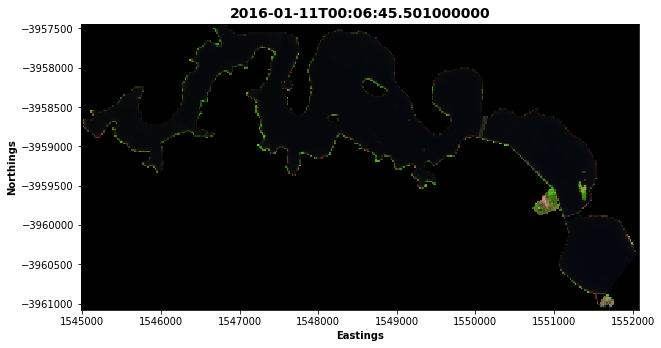

In [5]:
#plot false colour RGB image for one timeslice
DEAPlotting.three_band_image(ds_masked, bands=['nbart_swir_2', 'nbart_nir_1', 'nbart_green'], time=1)

In [6]:
#plot false colour RGB image for all times
# DEAPlotting.three_band_image_subplots(ds_masked, bands=['nbart_swir_2', 'nbart_nir_1', 'nbart_green'], num_cols =2)

## Explore current SDG water quality metrics

### Chlorophyll-a (CHLa) 

Chlorophyll-a (CHLa) is mapped using an ocean color approach, developed for coarse scale ocean monitoring satellites. The method is based on Reilly (2000), from which the most applicable version of the algorithm for Landsat 8 and Sentinel 2 is:
 
<img src="chla.png">
 
Where R4E is based on using the maximum of the 3 ratios described. The notation of those ratios is shorthand for R(443)/R(560). 
We will only use the first two ratios, given there is no band on LS8/S2 close to 510.
Strictly speaking R is equivalent to (NBAR/10000)/PI, but in ratios like this we should be ok.


TO DO

###  Total suspended sediment (TSS)

Total suspended sediment (TSS) is mapped using the method of Nechad (2010)(attached), where TSS = S:
 
 <img src="tss.png">
 
To apply this to the red band of Landsat 8 and Sentinel 2 we use:


Sentinel 2 - Ap = 355.85, Bp = 1.74, Cp = 0.1728

It's possible to test on other bands, up to the NIR. Particularly the red-edge bands for S2 might be interesting. We can get coefficients for those out of the paper if we try them.


The calculation of TSS was explored. However, results from the work, below, were incorrect (potentially relating to cloud). From the brief look we could not understand what the issues was. We decided not to spend time bug fixing. 

In [14]:
pw = math.pi * (ds_masked.nbart_red / 10_000)

In [15]:
tss_red = ((355.85 * pw) / (1-pw/0.1728)) + 1.74
# tss_rededge1 = ((ds_masked.nbart_red_edge_1 * 289.29)/((1-ds_masked.nbart_red_edge_1)/0.1686))+2.1

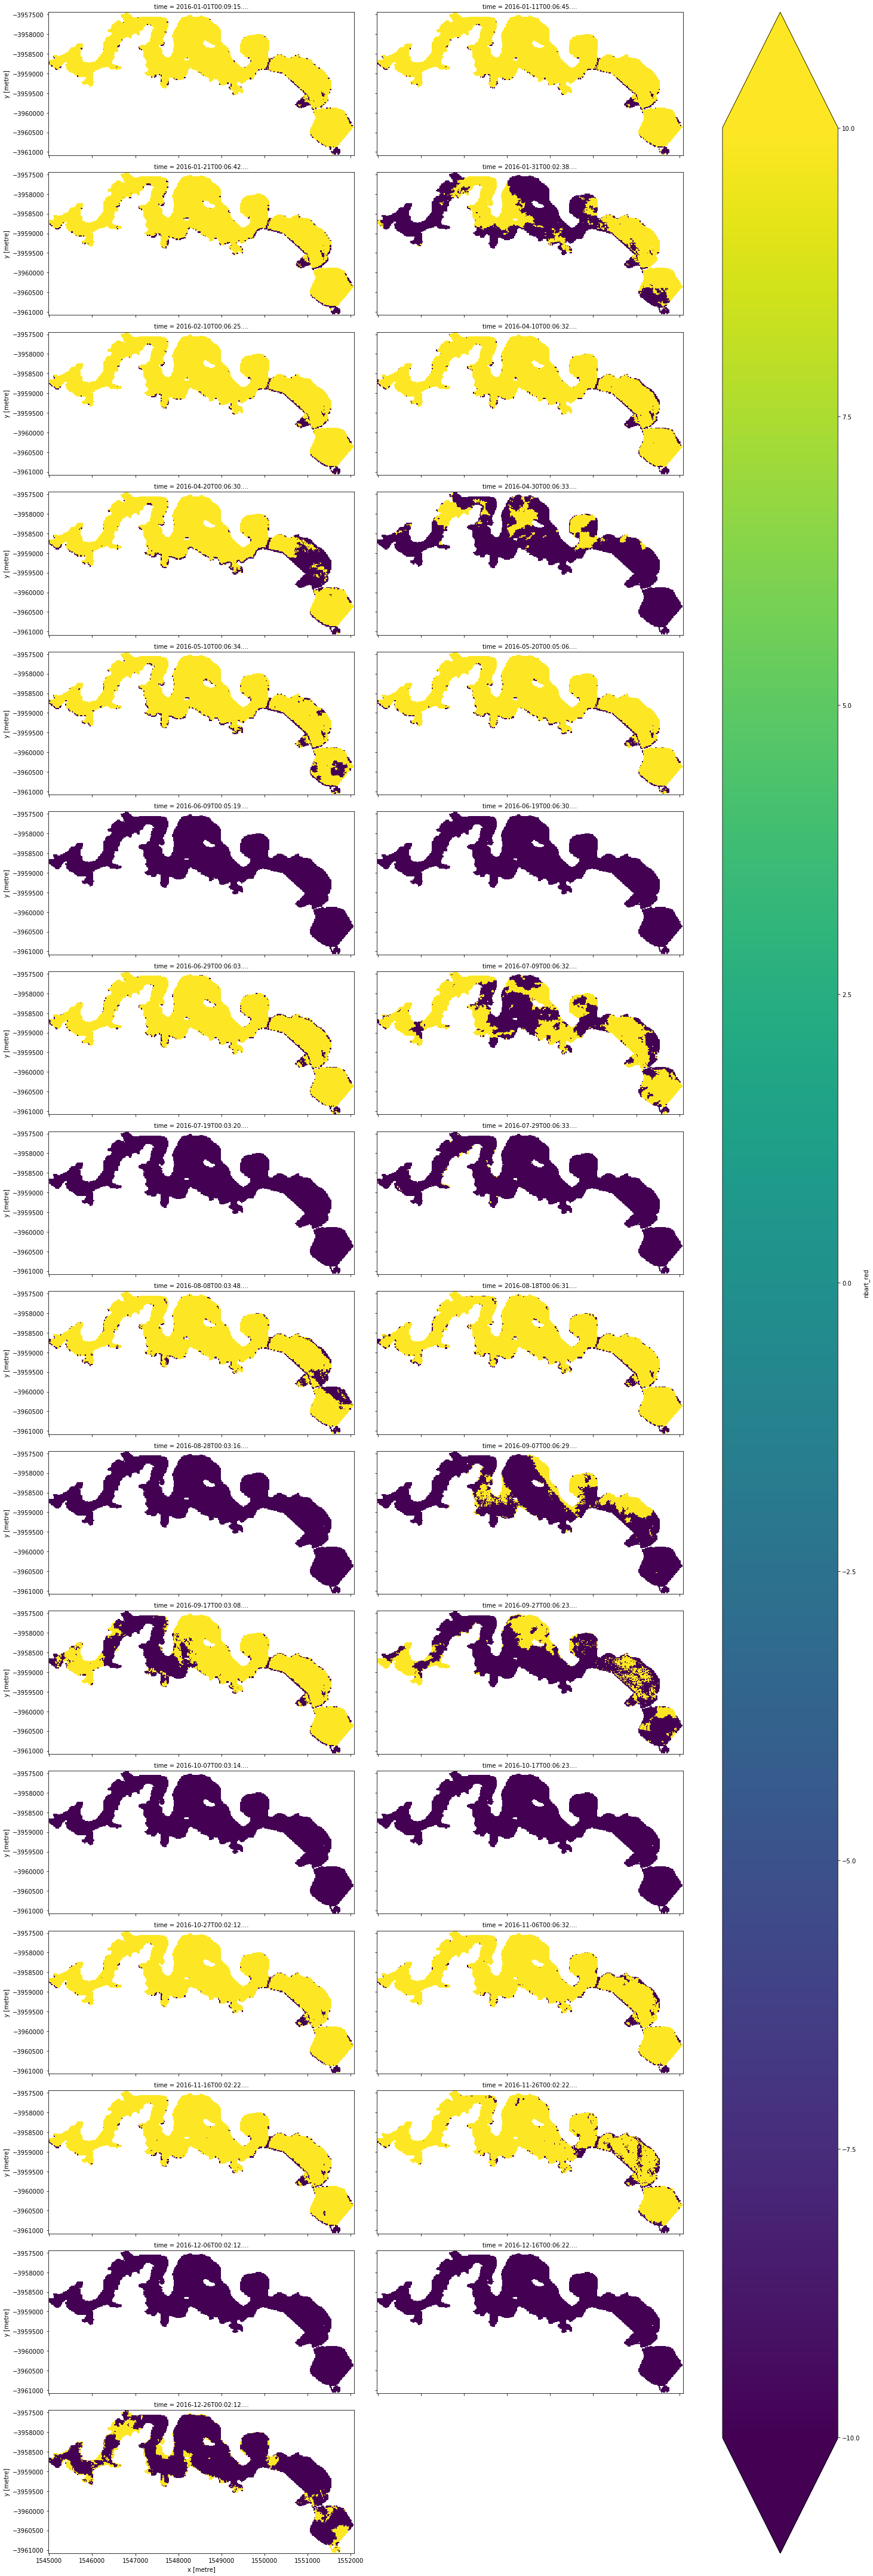

In [21]:
tss_red.plot(col='time', figsize=(20, 60),vmax = 10, vmin = -10, col_wrap = 2);

### Explore other water quality metrics

### Chlorophyll-a (CHLa) - Normalized difference chlorophyll index

Normalized difference chlorophyll index: A novel model for remote estimation of
chlorophyll-a concentration in turbid productive waters
Sachidananda Mishra, Deepak R. Mishra

In [15]:
#Calculate NDCI
ndci = (ds_masked.nbart_red_edge_1 - ds_masked.nbart_red) / (ds_masked.nbart_red_edge_1 + ds_masked.nbart_red)
ndci_ds = ndci.to_dataset(dim='ndci') #convert array to dataset

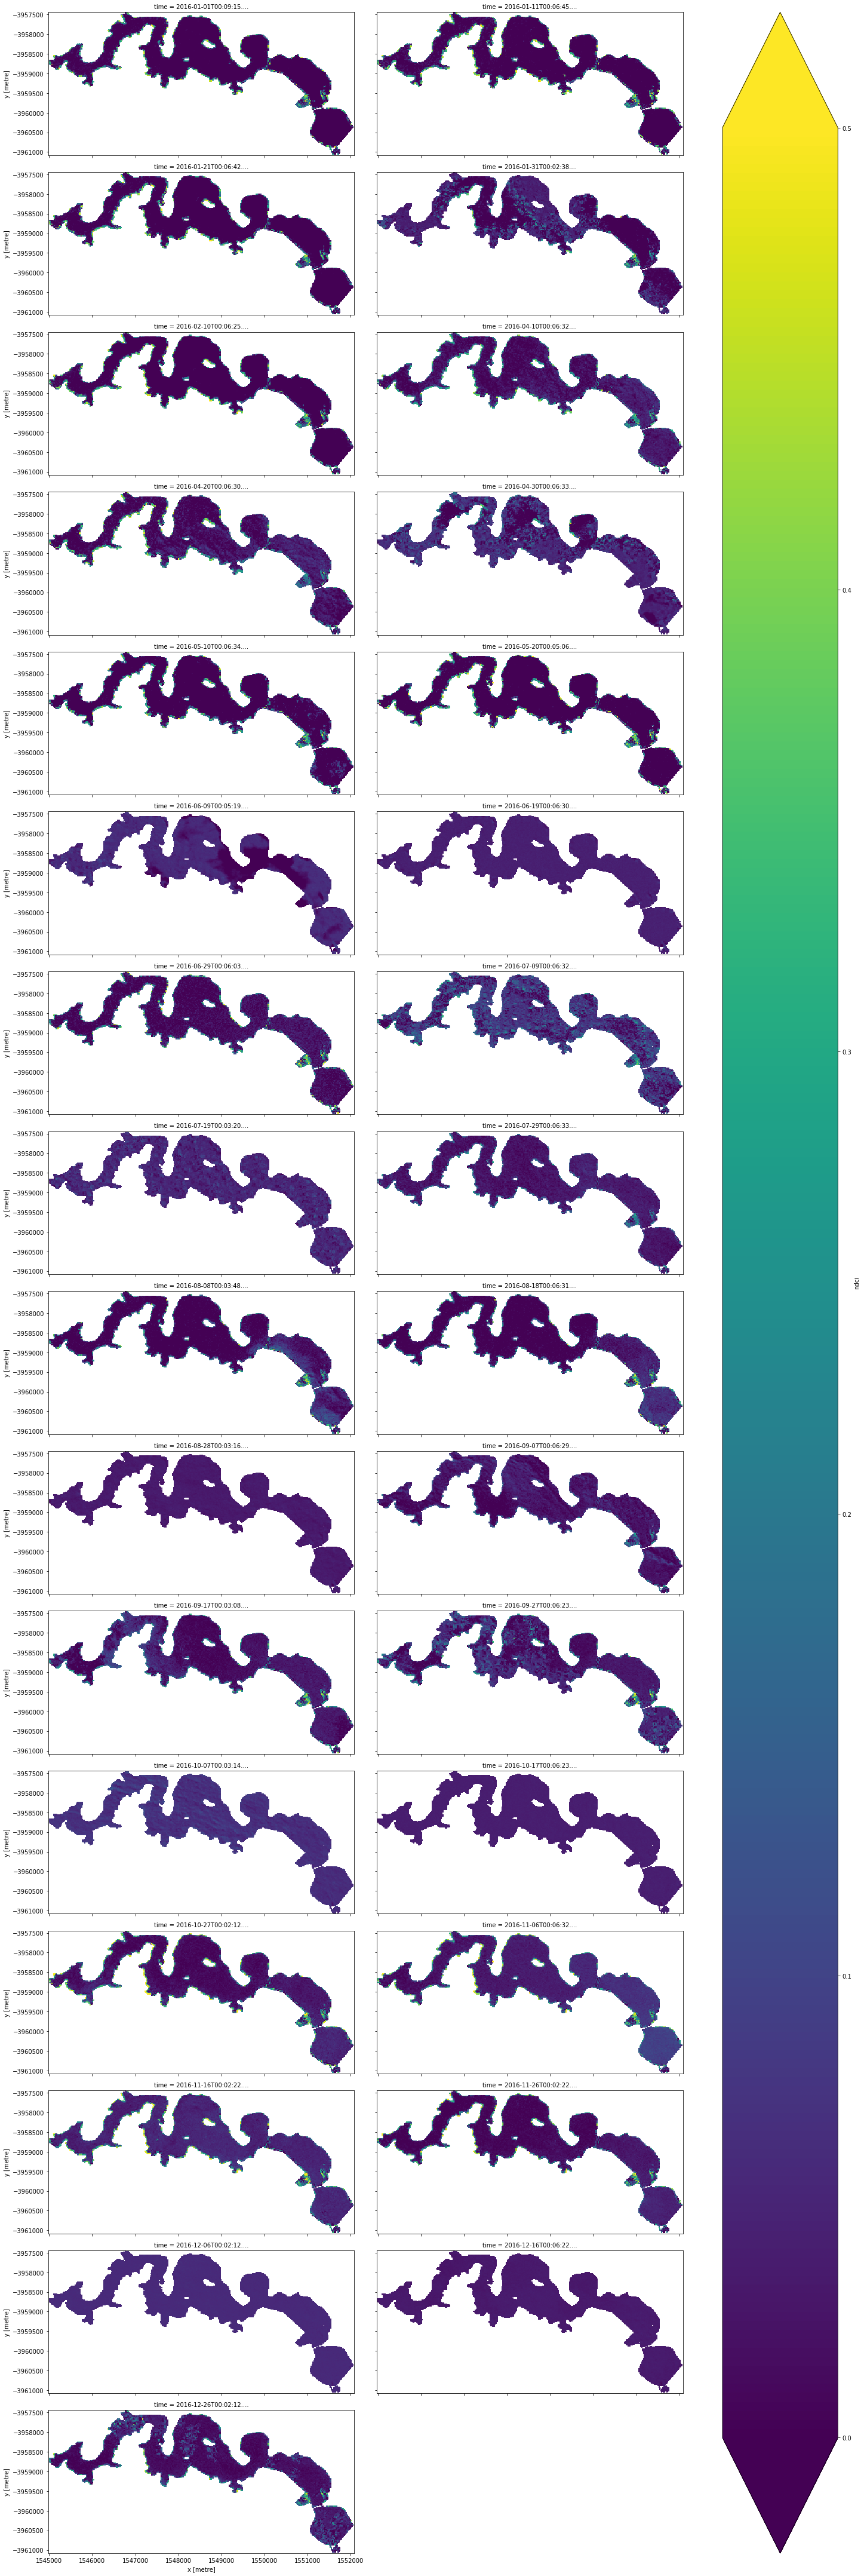

In [58]:
#Create a plot that examines all ndci time slices
ndci_ds.ndci.plot(col='time', figsize=(20, 60), vmin = 0, vmax = 0.5, col_wrap=2)

Generating 31 frame animation
    Exporting animation to /g/data/u46/users/ext547/ewater/notebooks/dea-notebooks/other_notebooks/sdg_hackathon/ndci_time_series.gif


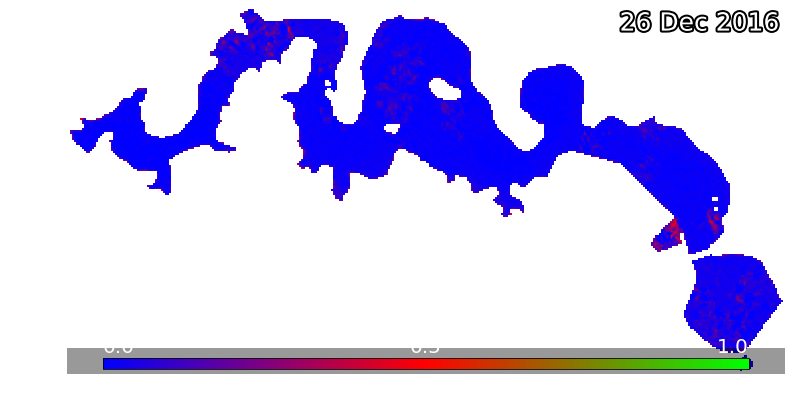

In [76]:
out_file = '/g/data/u46/users/ext547/ewater/notebooks/dea-notebooks/other_notebooks/sdg_hackathon/ndci_time_series.gif'

DEAPlotting.animated_timeseries(ds = ndci_ds,output_path=out_file, bands = ['ndci'],
                                time_dim = 'time', x_dim = 'x',y_dim = 'y',
                                show_date= True, onebandplot_cbar=True, 
                                onebandplot_kwargs={'cmap':'brg','vmin':0, 'vmax':1}, interval=1000)

## Code to load Landsat rather than Sentinel data

In [5]:
# #set up and query Landsat

# product_id = 'ls8_nbar_albers'
# query = {'geopolygon': geom,
#          #'lat': (-35.25, -35.35),
#          #'lon': (149.05, 149.17),
#          'time':('2017-01-01', '2017-01-15')}

# good_quality = masking.make_mask(sensor_pq.pixelquality,
#                                  cloud_acca='no_cloud',
#                                  cloud_fmask='no_cloud',
#                                  cloud_shadow_acca='no_cloud_shadow',
#                                  cloud_shadow_fmask='no_cloud_shadow',
#                                  blue_saturated=False,
#                                  green_saturated=False,
#                                  red_saturated=False,
#                                  nir_saturated=False,
#                                  swir1_saturated=False,
#                                  swir2_saturated=False,
#                                  contiguous=True)
# ds = dc.load(product=product_id, group_by='solar_day', **query)
# sensor_pq = dc.load(product=product_id, fuse_func=ga_pq_fuser, group_by='solar_day', **query)
# ds_clean = ds.where(good_quality)

# mask = rasterio.features.geometry_mask([geom.to_crs(ds_clean.geobox.crs) for geoms in [geom]],
#                                            out_shape=ds_clean.geobox.shape,
#                                            transform=ds_clean.geobox.affine,
#                                            all_touched=False,
#                                            invert=True)
# ds_masked = ds_clean.where(mask)
# ds_masked